# Open exploration - uncertainties

- Perform experiments for ten sampled policies *plus zero policy* and per policy 1,000 sampled scnenarios (both sampling using lhs).
- Evaluate the influence of different uncertainties have on the outcomes: (1) expected damage, (2) expected number of deaths, and (3) total costs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking, plotting)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id

In [8]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios= 1000, policies = 10) # using lhs sampling

save_results(results, './results/open_exploration_uncertainties_10000runs.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_10000runs.tar.gz


Wall time: 1h 27min 52s


In [3]:
results = load_results('./results/open_exploration_uncertainties_10000runs.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\results\open_exploration_uncertainties_10000runs.tar.gz


In [4]:
# use the same 1,000 sampled scenarios, run for zero policy
sampled_scenarios = experiments.loc[:, [u.name for u in dike_model.uncertainties]]
sampled_scenarios.drop_duplicates(inplace=True)
ref_scenarios = [Scenario(i, **scenario.to_dict())
                 for i, scenario in pd.DataFrame.from_dict(sampled_scenarios).iterrows()] # sampled scenarios

policy0 = {'DikeIncrease': 0, 'DaysToThreat': 0, 'RfR': 0}
ref_policy = {}
for key in dike_model.levers:
    _, s = key.name.split('_')
    if ' ' in s:
        s, _ = s.split(' ')
    ref_policy.update({key.name: policy0[s]})                

ref_policy0 = Policy('baseline', **ref_policy) # policy0

In [6]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios= ref_scenarios, policies = ref_policy0) # using lhs sampling

save_results(results, './results/open_exploration_uncertainties_policy0.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_policy0.tar.gz


Wall time: 14min 8s


In [5]:
results_policy0 = load_results('./results/open_exploration_uncertainties_policy0.tar.gz')

experiments_policy0, outcomes_policy0 = results_policy0

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\results\open_exploration_uncertainties_policy0.tar.gz


In [6]:
# concat the results of policy0 with previous experiments and outcomes
experiments_w0 = experiments.copy()
outcomes_w0 = outcomes.copy()

experiments_policy0.scenario = experiments_policy0.scenario.apply(lambda x: 100+x) # to fix the alignment between scenario naming
experiments_w0.policy = experiments_w0.policy.apply(lambda x: str(x))
experiments_w0 = pd.concat([experiments_policy0, experiments_w0], axis=0, sort=False)
experiments_w0.reset_index(drop=True, inplace=True)

for key in outcomes:
    outcomes_w0.update({key: np.append(outcomes_policy0[key], outcomes_w0[key])})

## The outcomes

We first inspect the outcomes by boxplots. From the graphs we can see that the results for *Total Investment Costs* is quite normally distributed (with outliers being the zero policy cases), while those for *Expected Annual Damage* and *Expected Number of Deaths* contain many extreme "outliers". These findings are aligned with the following parewise scatterplot.

Note that *Total Investment Costs* is only related to the levers.

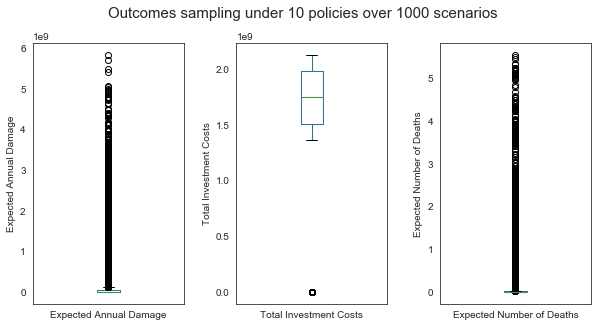

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace = 0.35, top = 0.85)
kpis = pd.DataFrame([key.name for key in dike_model.outcomes])
fig.suptitle('Outcomes sampling under 10 policies over 1000 scenarios', y=0.95, fontsize=15)

for i, key in kpis.iterrows():
    pd.Series(outcomes_w0[key[0]]).plot(kind='box', ax=axes[i], label=key[0])
    axes[i].set_ylabel(key[0])

## Pairwise scatterplot

From the graphs we can see that "no action" (zero policy) is NOT a good action: a random lever can significantly reduce the *Expected Number of Deaths* and *Expected Annual Damage*, although the *Total Investment Costs* resulted from the introduced lever could be around the same order of the damage.

We can also see that the outcomes of *Expected Number of Deaths* and *Expected Annual Damage* are highly correlated, and different policies result in different "damage-to-deaths" ratios across scenarios.

### *Pairwise plot showing sampled policies and also zero policy*

[MainProcess/INFO] no time dimension found in results


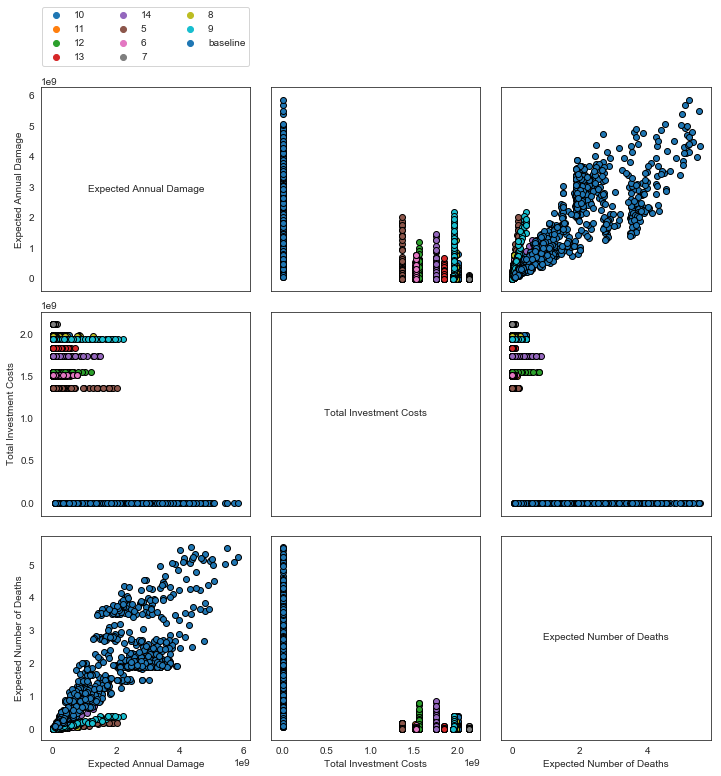

In [9]:
fig, ax = pairs_plotting.pairs_scatter(experiments_w0, outcomes_w0, group_by='policy', legend=True)
fig.set_size_inches([12, 12])

### *Pairwise plot showing only sampled policies*

[MainProcess/INFO] no time dimension found in results


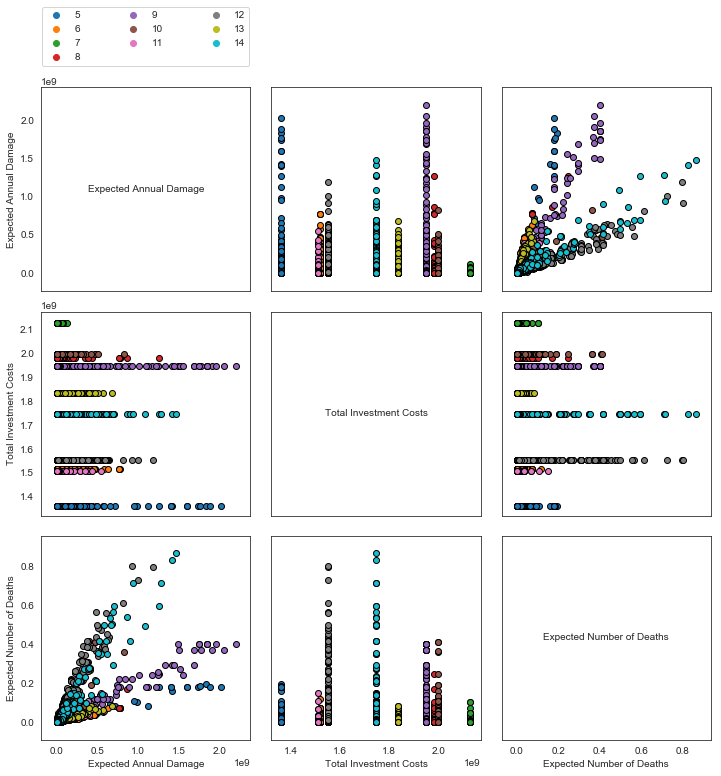

In [10]:
fig, ax = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy', legend=True)
fig.set_size_inches([12, 12])

## Feature scoring

We then perform feature scoring for all outcomes to find out on which outcome does which uncertainty has the largest influence. We drop the *Total Investment Costs* here as it is irrelevant to uncertainties.

From the results, we see that both *Expected Annual Damage* and *Expected Number of Deaths* are primarily influenced by **dike failure probability at Doesburg (A.1) and Zutphen (A.3)**, while the growth rates of breach width (Brate) seem to have limited influence on expected damage.

In [11]:
# remove investment costs as it is irrelevant to uncertainties
del outcomes_w0['Total Investment Costs']

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


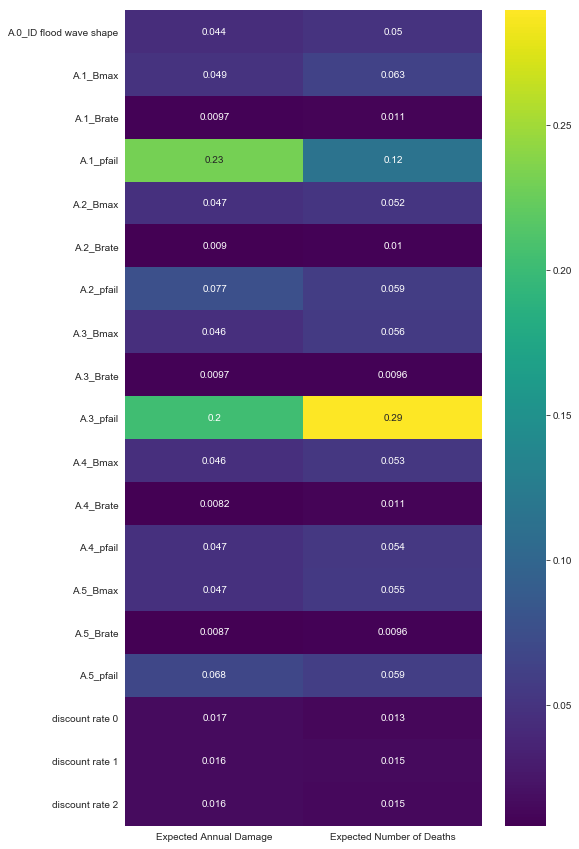

In [12]:
x = experiments_w0.drop(columns = [l.name for l in dike_model.levers]+['policy'])
y = outcomes_w0

fs = feature_scoring.get_feature_scores_all(x, y, alg='random forest')
plt.figure(figsize = (8,15))
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

## Dimensional stacking & PRIM

We can further apply dimensional stacking to create a heatmap showing the influences of the most important uncertainties, and PRIM to identify the range of those uncertainties. We can plot it for both expected damage and number of deaths. 

As we saw previously, the *Expected Annual Damage* and *Expected Number of Deaths* both have a very narrow box in the boxplot with quite some (extreme) outlies. We can therfore use Q3 as a threshold for these two outcomes of interest.

### 1. Expected Annual Damage < its 75th percentile

The dimensional stacking plot shows that the most powerful -------

[MainProcess/INFO] model dropped from analysis because only a single category


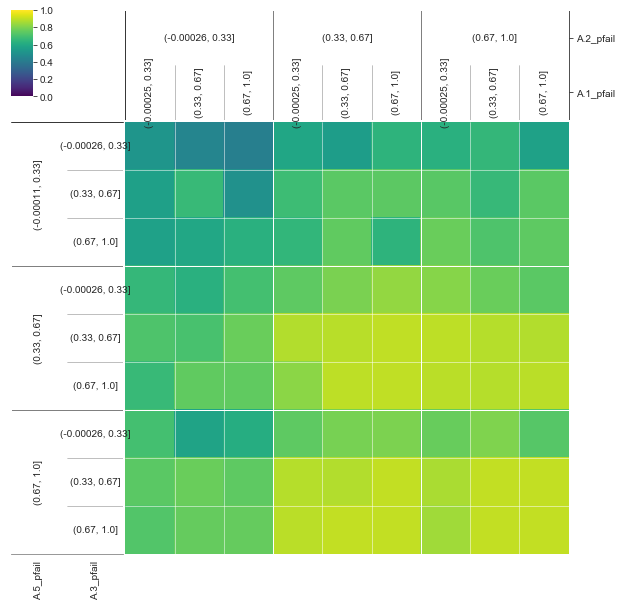

In [15]:
x = experiments_w0.drop(columns = [l.name for l in dike_model.levers]+['policy'])
y = outcomes_w0['Expected Annual Damage'] < np.percentile(outcomes_w0['Expected Annual Damage'], q=75)

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3, bin_labels=True)
plt.show()

In [16]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 11000 points remaining, containing 8250 cases of interest
[MainProcess/INFO] mean: 0.9090909090909091, mass: 0.199, coverage: 0.2412121212121212, density: 0.9090909090909091 restricted_dimensions: 6


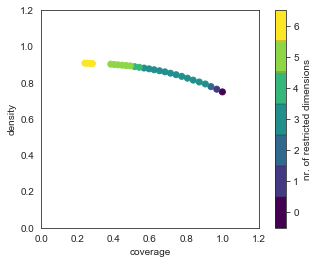

In [158]:
box1.show_tradeoff()
plt.show()

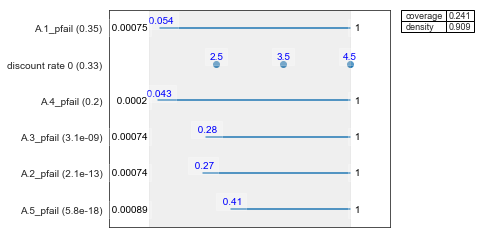

In [17]:
box1.inspect(style='graph')
plt.show()

### 2. Expected Number of Deaths < its 75th percentile

In [18]:
# check the threshold value
print('The Q3 for expected number of deaths here is {} person(s).'.format(np.percentile(outcomes_w0['Expected Number of Deaths'], q=75)))

The Q3 for expected number of deaths here is 0.011884826725346418 person(s).


[MainProcess/INFO] model dropped from analysis because only a single category


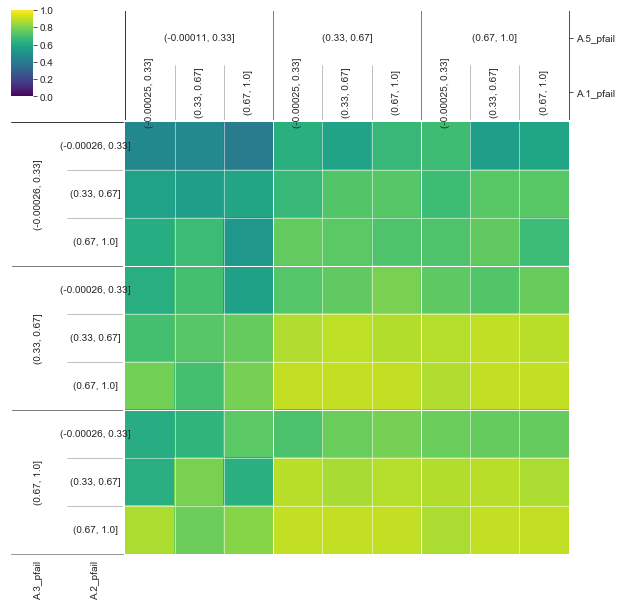

In [19]:
x = experiments_w0.drop(columns = [l.name for l in dike_model.levers]+['policy'])
y = outcomes_w0['Expected Number of Deaths'] < np.percentile(outcomes_w0['Expected Number of Deaths'], q=75)

dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3, bin_labels=True)
plt.show()

In [20]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box2 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 11000 points remaining, containing 8250 cases of interest
[MainProcess/INFO] mean: 0.9094113500176243, mass: 0.2579090909090909, coverage: 0.31272727272727274, density: 0.9094113500176243 restricted_dimensions: 5


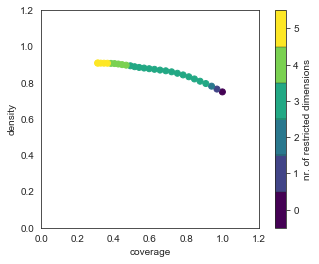

In [21]:
box2.show_tradeoff()
plt.show()

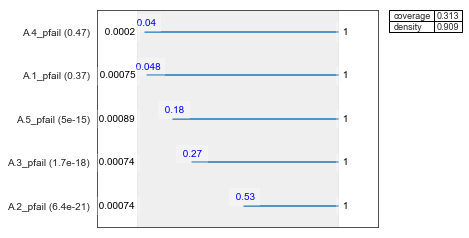

In [22]:
box2.inspect(style='graph')
plt.show()

## Appendix

#### *The ten sampled levers*

In [23]:
levers = experiments.loc[:, [l.name for l in dike_model.levers]]
levers = levers.drop_duplicates()
levers.index = experiments.policy.unique() # align with policy no.
levers.T # transpose for seeing all levers

,5,6,7,8,9,10,11,12,13,14
0_RfR 0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
0_RfR 1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
0_RfR 2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1_RfR 0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
1_RfR 1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1_RfR 2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
2_RfR 0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2_RfR 1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2_RfR 2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3_RfR 0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
